In [60]:
import torch
import torchvision
from torch.nn import functional as F
import torchvision.transforms.functional as transFunc
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt

In [85]:
#Basic Transforms
transform = transforms.Compose([transforms.Resize(16), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
#Resize to 64 is updated, our images are 32 x 32!
#Start Small and Get Bigger, means keeps the size of image 16, then 32 and so on and check the performance of the model

In [86]:
trainset = torchvision.datasets.CIFAR10(root='/home/mayur/Desktop/Pytorch/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [87]:
testset = torchvision.datasets.CIFAR10(root='/home/mayur/Desktop/Pytorch/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Changes in image size after resize transform.

```python
img, label = cifar_2[0]
print(img.shape)
```

In [88]:
#Label Mapping - classification of two class 

#CIFAR has 10 classes, we are restricting it into 2 classes
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar_2 = [(img, label_map[label1]) for img, label1 in trainset if label1 in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in testset if label in [0, 2]]

trainloader = torch.utils.data.DataLoader(cifar_2, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)

In [89]:
transfer_model = models.resnet34(pretrained=True)

In [90]:
# Freezing exisiting Parameters, By keeping parameters as false the resnet's parameter won't under go backprop !
for name, param in transfer_model.named_parameters():
    param.requires_grad = False

TIP

You might not want to freeze the BatchNorm layers in a model, as they will be trained to approximate the mean and standard deviation of the dataset that the model was originally trained on, not the dataset that you want to fine-tune on. Some of the signal from your data may end up being lost as BatchNorm corrects your input. You can look at the model structure and freeze only layers that aren’t BatchNorm like this:

In [91]:
transfer_model = models.resnet34(pretrained=True)
for name, param in transfer_model.named_parameters():
    if ('bn' not in name):
        param.requires_grad = False

### Adding a New Layer to pretrained Model

In [92]:
for name, param in transfer_model.named_parameters():
    if ('fc' in name):
        print(param.shape)

torch.Size([1000, 512])
torch.Size([1000])


In [93]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500), nn.ReLU(), nn.Dropout(), nn.Linear(500, 2))

In [94]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

### Finding Better Learning Rate

The idea is quite simple: over the course of an epoch, start out with a small learning rate and increase to a higher learning rate over each mini-batch, resulting in a high rate at the end of the epoch. Calculate the loss for each rate and then, looking at a plot, pick the learning rate that gives the greatest decline. 

In [95]:
### Finding learning rate implemented in fast.ai

import math
def find_lr(model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(trainloader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trainloader:
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

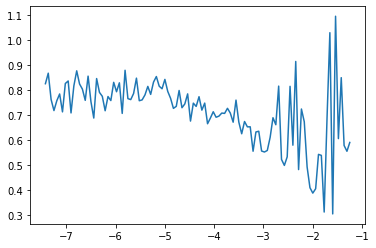

In [96]:
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
transfer_model.to(device)
logs,losses = find_lr(transfer_model, torch.nn.CrossEntropyLoss(), optimizer)
plt.plot(logs,losses)
#near 1e-2

In [97]:
def train(model, optimizer, loss_fn, trainloader, testloader, n_epochs, device):
    for epoch in range(1, n_epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch in trainloader:
            img, label = batch
            img = img.to(device)
            label = label.to(device)
            
            output = model(img)
            optimizer.zero_grad()
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(trainset)
        
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in testloader:
            img, label = batch
            img = img.to(device)
            label = label.to(device)
            
            output = model(img)
            loss = loss_fn(output, label)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output),dim=1)[1], label).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
            
        valid_loss/=len(testset)
        
        print(f'Epoch: {epoch}, Training Loss: {training_loss:.3f}, Validation Loss: {valid_loss:.3f}, Accuracy: {num_correct/num_examples}')

In [98]:
### Pretrained Model
optimizer = optim.Adam(transfer_model.parameters(), lr=0.01)
transfer_model.to(device)
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), trainloader, testloader, n_epochs=20, device=device)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8635
Epoch: 2, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.875
Epoch: 3, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.857
Epoch: 4, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.864
Epoch: 5, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.882
Epoch: 6, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8715
Epoch: 7, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.886
Epoch: 8, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8885
Epoch: 9, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8875
Epoch: 10, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8745
Epoch: 11, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8825
Epoch: 12, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.89
Epoch: 13, Training Loss: 0.001, Validation Loss: 0.004, Accuracy: 0.7535
Epoch: 14, Training Loss: 0.001, Validation Loss: 0.00

### Differential Learning Rate

Fine-tune some of the layers of, say, the ResNet model we’re using. Perhaps adding some training to the layers just preceding our classifier will make our model just a little more accurate. But as those preceding layers have already been trained on the ImageNet dataset, maybe they need only a little bit of training as compared to our newer layers. We are training existing layers of resnet with different learning rate.

In [99]:
optimizer = optim.Adam([
{ 'params': transfer_model.layer4.parameters(), 'lr': 1e-2 /3},
{ 'params': transfer_model.layer3.parameters(), 'lr': 1e-2 /9},
], lr=1e-2)

In [100]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

In [101]:
### Pretrained Model
optimizer = optim.Adam(transfer_model.parameters(), lr=0.01)
transfer_model.to(device)
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), trainloader, testloader, n_epochs=20, device=device)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1, Training Loss: 0.001, Validation Loss: 0.003, Accuracy: 0.6995
Epoch: 2, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.886
Epoch: 3, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8965
Epoch: 4, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8985
Epoch: 5, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.911
Epoch: 6, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.902
Epoch: 7, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8945
Epoch: 8, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.903
Epoch: 9, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.903
Epoch: 10, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.904
Epoch: 11, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.903
Epoch: 12, Training Loss: 0.001, Validation Loss: 0.077, Accuracy: 0.772
Epoch: 13, Training Loss: 0.001, Validation Loss: 0.001, Accuracy: 0.8545
Epoch: 14, Training Loss: 0.001, Validation Loss: 0.003

### Data Augmentation

>**Color Jitter** - randomly changes the brightness, contrast, saturation, and hue of an image. For brightness, contrast, and saturation, you can supply either a float or a tuple of floats, all nonnegative in the range 0 to 1, and the randomness will either be between 0 and the supplied float or it will use the tuple to generate randomness between the supplied pair of floats. For hue, a float or float tuple between –0.5 and 0.5 is required, and it will generate random hue adjustments between [-hue,hue] or [min, max]
```python
torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
```
>**Flip** - If you want to flip your image, these two transforms randomly reflect an image on either the horizontal or vertical axis:
```python
torchvision.transforms.RandomHorizontalFlip(p=0.5)

torchvision.transforms.RandomVerticalFlip(p=0.5)
````
>**RandomGrayscale** is a similar type of transformation, except that it randomly turns the image grayscale, depending on the parameter p (the default is 10%):
```python
 torchvision.transforms.RandomGrayscale(p=0.1)
``` 
>**RandomCrop** and **RandomResizeCrop**, as you might expect, perform random crops on the image of size, which can either be an int for height and width, or a tuple containing different heights and widths. 
>RandomResizeCrop is using Bilinear interpolation, but you can also select nearest neighbor or bicubic interpolation by changing the interpolation parameter. See the PIL filters page for further details. 
>By default, RandomResize is using constant padding, which fills out the otherwise empty pixels beyond the image with the value given in fill. However, I recommend that you use the reflect padding instead, as empirically it seems to work a little better than just throwing in empty constant space. 
```python
torchvision.transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')

torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
```
>**RandomRotation**, If you’d like to randomly rotate an image, RandomRotation will vary between [-degrees, degrees] if degrees is a single float or int, or (min,max) if it is a tuple:
>If expand is set to True, this function will expand the output image so that it can include the entire rotation; by default, it’s set to crop to within the input dimensions. You can specify a PIL resampling filter, and optionally provide an (x,y) tuple for the center of rotation; otherwise the transform will rotate about the center of the image.
```python
torchvision.transforms.RandomRotation(degrees, resample=False,expand=False, center=None)
```
>**Pad** is a general-purpose padding transform that adds padding (extra height and width) onto the borders of an image. A single value in padding will apply padding on that length in all directions. A two-tuple padding will produce padding in the length of (left/right, top/bottom), and a four-tuple will produce padding for (left, top, right, bottom). By default, padding is set to constant mode, which copies the value of fill into the padding slots. The other choices are edge, which pads the last values of the edge of the image into the padding length; reflect, which reflects the values of the image (except the edge) into the border; and symmetric, which is reflection but includes the last value of the image at the edge. 
```python
torchvision.transforms.Pad(padding, fill=0, padding_mode=constant)
```
>**RandomAffine** allows you to specify random affine translations of the image (scaling, rotations, translations, and/or shearing, or any combination).
The degrees parameter is either a single float or int or a tuple. In single form, it produces random rotations between (–degrees, degrees). With a tuple, it will produce random rotations between (min, max). degrees has to be explicitly set to prevent rotations from occurring—there’s no default setting. translate is a tuple of two multipliers (horizontal_multipler, vertical_multiplier). At transform time, a horizontal shift, dx, is sampled in the range –image_width × horizontal_multiplier < dx < img_width × horizontal_width, and a vertical shift is sampled in the same way with respect to the image height and the vertical multiplier. Scaling is handled by another tuple, (min, max), and a uniform scaling factor is randomly sampled from those. Shearing can be either a single float/int or a tuple, and randomly samples in the same manner as the degrees parameter. Finally, resample allows you to optionally provide a PIL resampling filter, and fillcolor is an optional int specifying a fill color for areas inside the final image that lie outside the final transform.
```python
torchvision.transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0)
```
    Widely Done Transformations -  Random flips, color jittering, rotation, and crops to start.

### Custom Transforms

>**Color Spaces and Lambda Transforms**, This may seem a little odd to even bring up, but so far all our image work has been in the fairly standard 24-bit RGB color space, where every pixel has an 8-bit red, green, and blue value to indicate the color of that pixel. However, other color spaces are available!

>A popular alternative is HSV, which has three 8-bit values for hue, saturation, and value. Some people feel this system more accurately models human vision than the traditional RGB color space. But why does this matter? A mountain in RGB is a mountain in HSV, right?

>Well, there’s some evidence from recent deep learning work in colorization that other color spaces can produce slightly higher accuracy than RGB. A mountain may be a mountain, but the tensor that gets formed in each space’s representation will be different, and one space may capture something about your data better than another.

>When combined with ensembles, you could easily create a series of models that combines the results of training on RGB, HSV, YUV, and LAB color spaces to wring out a few more percentage points of accuracy from your prediction pipeline.

>One slight problem is that PyTorch doesn’t offer a transform that can do this. But it does provide a couple of tools that we can use to randomly change an image from standard RGB into HSV (or another color space). First, if we look in the PIL documentation, we see that we can use Image.convert() to translate a PIL image from one color space to another. We could write a custom transform class to carry out this conversion, but PyTorch adds a transforms.Lambda class so that we can easily wrap any function and make it available to the transform pipeline. 

```python
def _random_colour_space(x):
    output = x.convert('HSV')
    return output
```

>This is then wrapped in a transforms.Lambda class and can be used in any standard transformation pipeline like we’ve seen before:

```python
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))
```
>That’s fine if we want to convert every image into HSV, but really we don’t want that. We’d like it to randomly change images in each batch, so it’s probable that the image will be presented in different color spaces in different epochs. We could update our original function to generate a random number and use that to generate a random probability of changing the image, but instead we’re even lazier and use RandomApply:

```python
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])
```

>By default, RandomApply fills in a parameter p with a value of 0.5, so there’s a 50/50 chance of the transform being applied. Experiment with adding more color spaces and the probability of applying the transformation to see what effect it has on our cat and fish problem.

### Custom Transform Classes

>Sometimes a simple lambda isn’t enough; maybe we have some initialization or state that we want to keep track of, for example. In these cases, we can create a custom transform that operates on either PIL image data or a tensor. Such a class has to implement two methods: \__call__, which the transform pipeline will invoke during the transformation process; and \__repr__, which should return a string representation of the transform, along with any state that may be useful for diagnostic purposes.

>In the following code, we implement a transform class that adds random Gaussian noise to a tensor. When the class is initialized, we pass in the mean and standard distribution of the noise we require, and during the \__call__ method, we sample from this distribution and add it to the incoming tensor:

```python
class Noise():
    """Adds gaussian noise to a tensor.

        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},
               stddev={self.stddev})"
        return repr
````
>If we add this to a pipeline, we can see the results of the \__repr__ method being called:

```python
transforms.Compose([Noise(0.1, 0.05)])
>> Compose(
    Noise(mean=0.1,sttdev=0.05)
)
```

**Start Small and Get Bigger!**

Here’s a tip that seems odd, but obtains real results: start small and get bigger. What I mean is if you’re training on 256 × 256 images, create a few more datasets in which the images have been scaled to 64 × 64 and 128 × 128. Create your model with the 64 × 64 dataset, fine-tune as normal, and then train the exact same model with the 128 × 128 dataset. Not from scratch, but using the parameters that have already been trained. Once it looks like you’ve squeezed the most out of the 128 × 128 data, move on to your target 256 × 256 data. You’ll probably find a percentage point or two improvement in accuracy.

While we don’t know exactly why this works, the working theory is that by training at the lower resolutions, the model learns about the overall structure of the image and can refine that knowledge as the incoming images expand. But that’s just a theory. However, that doesn’t stop it from being a good little trick to have up your sleeve when you need to squeeze every last bit of performance from a model.

If you don’t want to have multiple copies of a dataset hanging around in storage, you can use torchvision transforms to do this on the fly using the Resize function:
```python
resize = transforms.Compose([ transforms.Resize(64),
 …_other augmentation transforms_…
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
```
The penalty you pay here is that you end up spending more time in training, as PyTorch has to apply the resize every time. If you resized all the images beforehand, you’d likely get a quicker training run, at the expense of filling up your hard drive. But isn’t that trade-off always the way?

The concept of starting small and then getting bigger also applies to architectures. Using a ResNet architecture like ResNet-18 or ResNet-34 to test out approaches to transforms and get a feel for how training is working provides a much tighter feedback loop than if you start out using a ResNet-101 or ResNet-152 model. Start small, build upward, and you can potentially reuse the smaller model runs at prediction time by adding them to an ensemble model.

Ensembles
What’s better than one model making predictions? Well, how about a bunch of them? Ensembling is a technique that is fairly common in more traditional machine learning methods, and it works rather well in deep learning too. The idea is to obtain a prediction from a series of models, and combine those predictions to produce a final answer. Because different models will have different strengths in different areas, hopefully a combination of all their predictions will produce a more accurate result than one model alone.

There are plenty of approaches to ensembles, and we won’t go into all of them here. Instead, here’s a simple way of getting started with ensembles, one that has eeked out another 1% of accuracy in my experience; simply average the predictions:

**Assuming you have a list of models in models, and input is your input tensor**
```python
predictions = [m[i].fit(input) for i in models]
avg_prediction = torch.stack(b).mean(0).argmax()
```

The stack method concatenates the array of tensors together, so if we were working on the cat/fish problem and had four models in our ensemble, we’d end up with a 4 × 2 tensor constructed from the four 1 × 2 tensors. And mean does what you’d expect, taking the average, although we have to pass in a dimension of 0 to ensure that it takes an average across the first dimension instead of simply adding up all the tensor elements and producing a scalar output. Finally, argmax picks out the tensor index with the highest element, as you’ve seen before.

It’s easy to imagine more complex approaches. Perhaps weights could be added to each individual model’s prediction, and those weights adjusted if a model gets an answer right or wrong. What models should you use? I’ve found that a combination of ResNets (e.g., 34, 50, 101) work quite well, and there’s nothing to stop you from saving your model regularly and using different snapshots of the model across time in your ensemble!